In [2]:
## LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


randomseed = 1234

## DATA LOADING AND PREPROCESSING
# Load the data
gym = pd.read_csv('../../gym_members_exercise_tracking.csv')

# set 'Gender', 'Workout_Type', 'Workout_Frequency (days/week)' and 'Experience_Level' as categorical
for col in ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level']:
    gym[col] = gym[col].astype('category')

# log transform Weight and BMI
gym['Weight (kg)'] = np.log1p(gym['Weight (kg)'])

# transform 'Fat_Percentage'
max_fat = gym['Fat_Percentage'].max()
gym['Fat_Percentage'] = gym['Fat_Percentage'].apply(lambda x: np.sqrt(max_fat+1)-x)

# rename transformed columns
gym.rename(columns={'Weight (kg)': 'LWeight', 'Fat_Percentage': 'SFat_Percentage'}, inplace=True)

gym.drop(columns=['BMI'], inplace=True)

# divide into train and test set
gym_train, gym_test = train_test_split(gym, test_size=0.2, random_state=randomseed)

# Create gym_train_scale, gym_test_scale
gym_train_scale = gym_train.copy()
gym_test_scale = gym_test.copy()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.fit_transform(gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])

gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.transform(gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])


# Create X_train_exp_level, X_test_exp_level, y_train_exp_level, y_test_exp_level
X_train_exp_level = gym_train.drop(columns=['Experience_Level'])
X_train_exp_level_scale = gym_train_scale.drop(columns=['Experience_Level'])
y_train_exp_level = gym_train['Experience_Level']
X_test_exp_level = gym_test.drop(columns=['Experience_Level'])
X_test_exp_level_scale = gym_test_scale.drop(columns=['Experience_Level'])
y_test_exp_level = gym_test['Experience_Level']

# Create X_train_calories, X_test_calories, y_train_calories, y_test_calories
X_train_calories = gym_train.drop(columns=['Calories_Burned'])
X_train_calories_scale = gym_train_scale.drop(columns=['Calories_Burned'])
y_train_calories = gym_train['Calories_Burned']
X_test_calories = gym_test.drop(columns=['Calories_Burned'])
X_test_calories_scale = gym_test_scale.drop(columns=['Calories_Burned'])
y_test_calories = gym_test['Calories_Burned']

print("Data loaded and preprocessed")

Data loaded and preprocessed


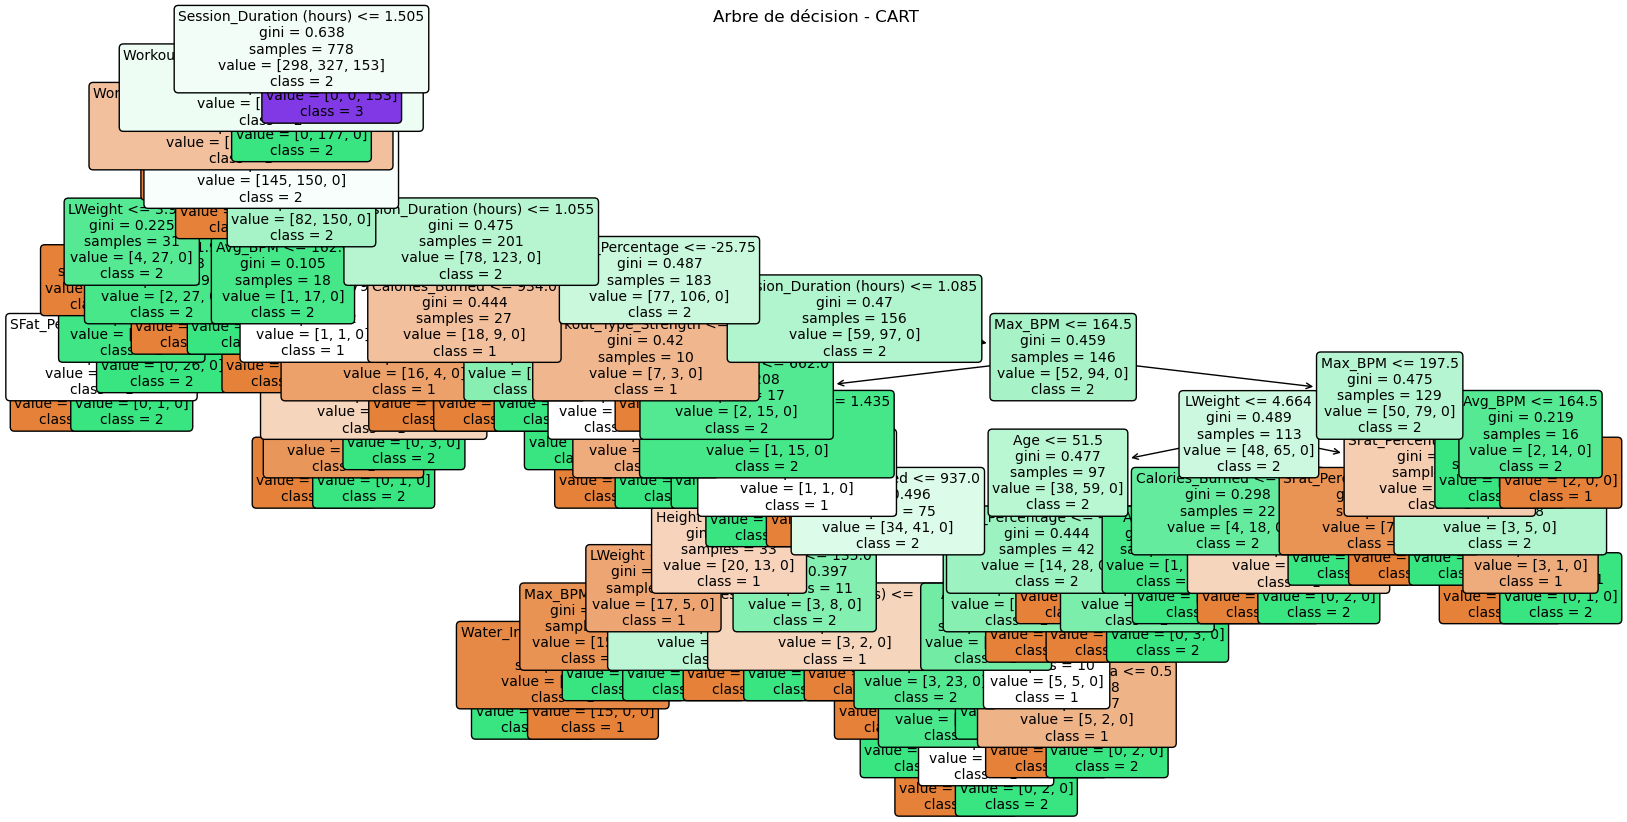

Accuracy CART (test): 0.8769
Accuracy CART (train): 1.0


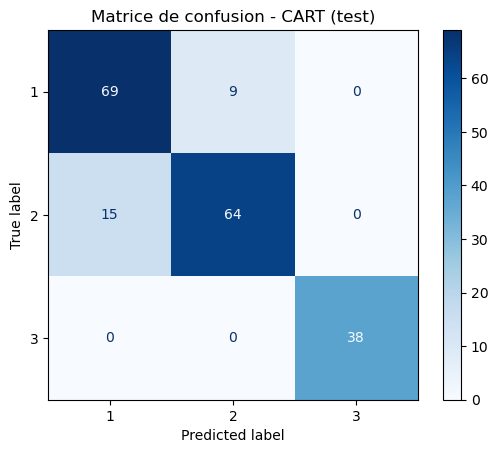

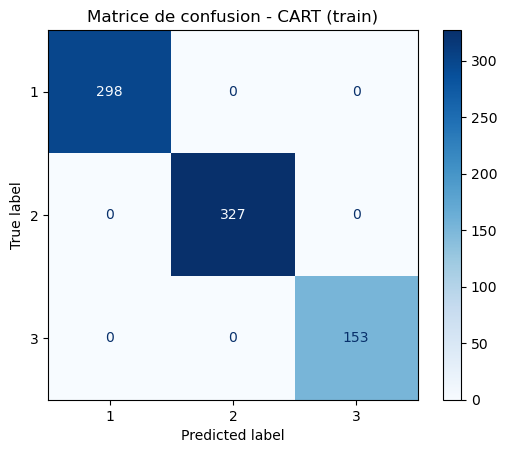

In [3]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier


# One-Hot Encoding des variables catégorielles
X_train_exp_level_encoded = pd.get_dummies(X_train_exp_level)
X_test_exp_level_encoded = pd.get_dummies(X_test_exp_level)

# Assurer que les colonnes de train et test sont alignées
X_train_exp_level_encoded, X_test_exp_level_encoded = X_train_exp_level_encoded.align(X_test_exp_level_encoded, join='left', axis=1, fill_value=0)

# Initialiser le modèle CART
cart_model = DecisionTreeClassifier(random_state=randomseed)

# Entraîner sur les données encodées
cart_model.fit(X_train_exp_level_encoded, y_train_exp_level)

# Prédictions
y_pred_cart = cart_model.predict(X_test_exp_level_encoded)

# Affichage de l'arbre
plt.figure(figsize=(20, 10))
tree.plot_tree(
    cart_model, 
    feature_names=X_train_exp_level_encoded.columns.tolist(),
    class_names=cart_model.classes_.astype(str).tolist(),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision - CART")
plt.show()

# Évaluation
conf_mat_cart_test = confusion_matrix(y_test_exp_level, y_pred_cart)
conf_mat_cart_train = confusion_matrix(y_train_exp_level, cart_model.predict(X_train_exp_level_encoded))

print("Accuracy CART (test):", round(accuracy_score(y_test_exp_level, y_pred_cart), 4))
print("Accuracy CART (train):", round(accuracy_score(y_train_exp_level, cart_model.predict(X_train_exp_level_encoded)), 4))

ConfusionMatrixDisplay(conf_mat_cart_test, display_labels=cart_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART (test)")
plt.show()

ConfusionMatrixDisplay(conf_mat_cart_train, display_labels=cart_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART (train)")
plt.show()

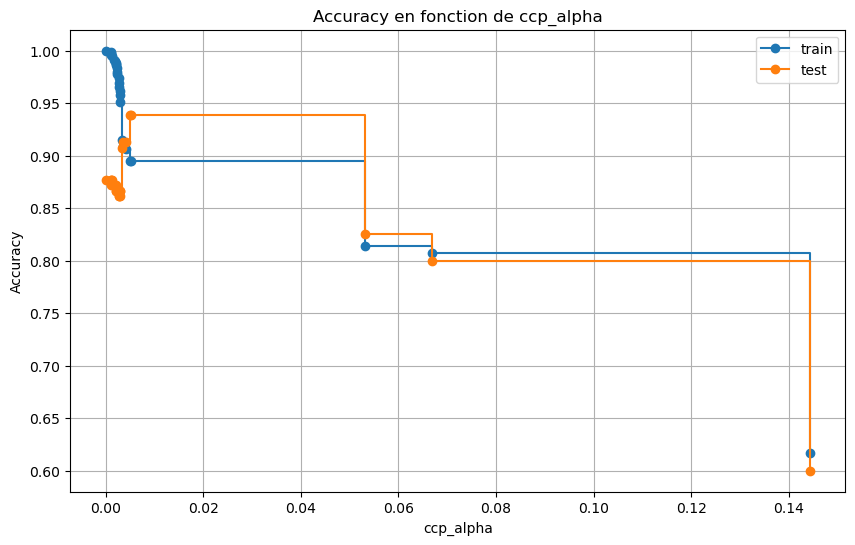

Meilleur ccp_alpha : 0.00492


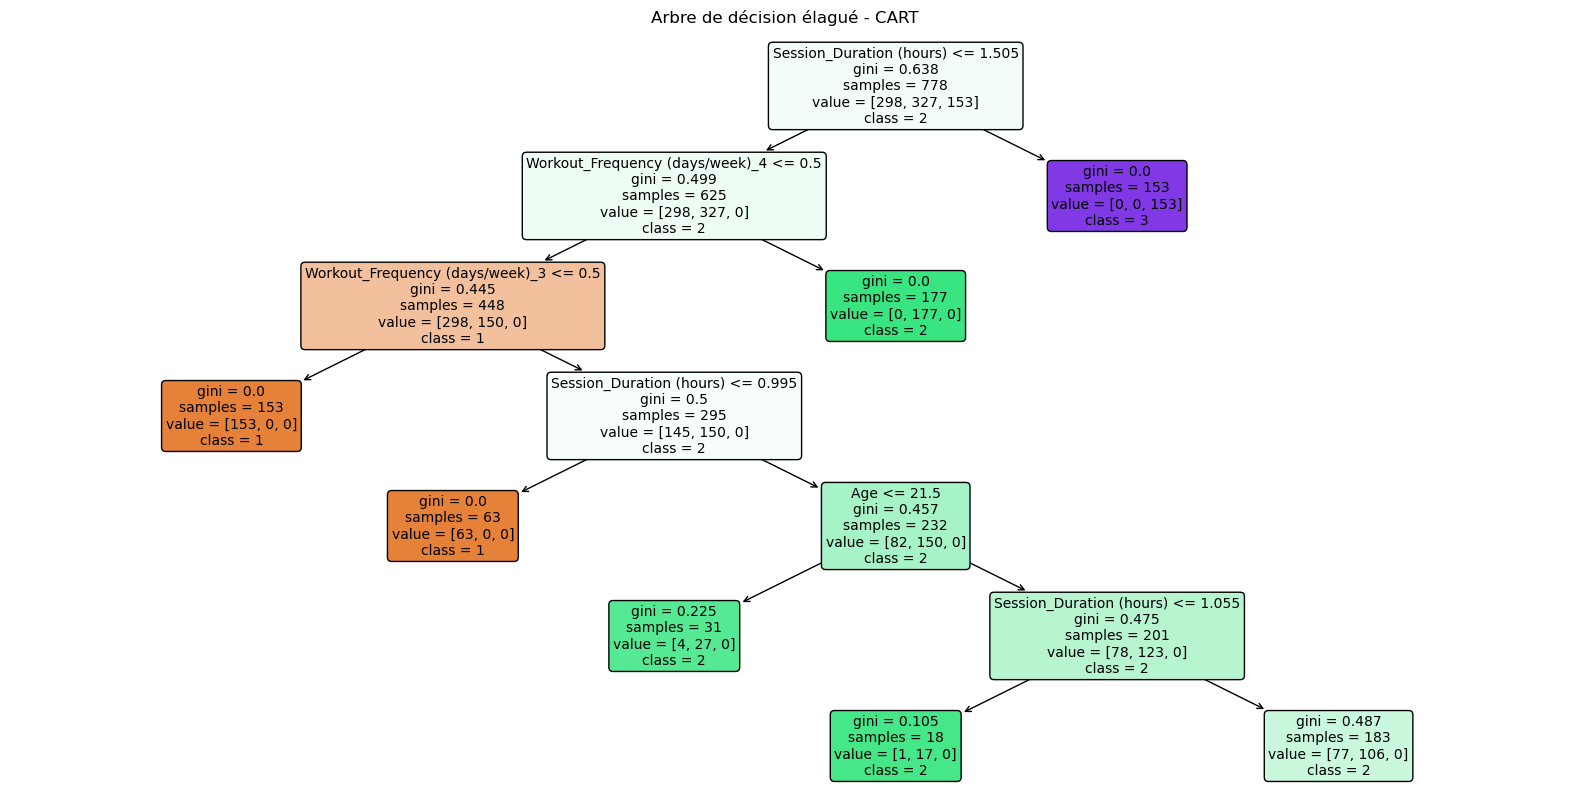

In [4]:
# Re-créer un arbre sans élagage
cart_model_full = DecisionTreeClassifier(random_state=randomseed, ccp_alpha=0.0)
cart_model_full.fit(X_train_exp_level_encoded, y_train_exp_level)


# Extraire les valeurs de ccp_alpha possibles
path = cart_model_full.cost_complexity_pruning_path(X_train_exp_level_encoded, y_train_exp_level)

ccp_alphas = path.ccp_alphas[:-1]
impurities = path.impurities[:-1]


# Liste pour stocker les modèles entraînés pour chaque ccp_alpha
models = []

for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=randomseed, ccp_alpha=ccp_alpha)
    model.fit(X_train_exp_level_encoded, y_train_exp_level)
    models.append(model)

# Accuracy pour chaque arbre
train_scores = [model.score(X_train_exp_level_encoded, y_train_exp_level) for model in models]
test_scores = [model.score(X_test_exp_level_encoded, y_test_exp_level) for model in models]

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy en fonction de ccp_alpha")
plt.grid()
plt.show()

# Choisir le modèle avec la meilleure accuracy sur le test
best_idx = np.argmax(test_scores)
best_ccp_alpha = ccp_alphas[best_idx]
print(f"Meilleur ccp_alpha : {best_ccp_alpha:.5f}")

# Recréer l'arbre élagué
cart_model_pruned = DecisionTreeClassifier(random_state=randomseed, ccp_alpha=best_ccp_alpha)
cart_model_pruned.fit(X_train_exp_level_encoded, y_train_exp_level)


plt.figure(figsize=(20, 10))
tree.plot_tree(
    cart_model_pruned, 
    feature_names=X_train_exp_level_encoded.columns.tolist(), 
    class_names=cart_model_pruned.classes_.astype(str).tolist(),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision élagué - CART")
plt.show()



Accuracy CART élagué (test): 0.9385
Accuracy CART élagué (train): 0.8946


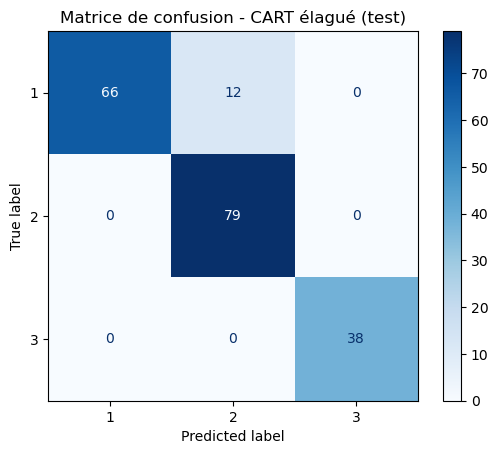

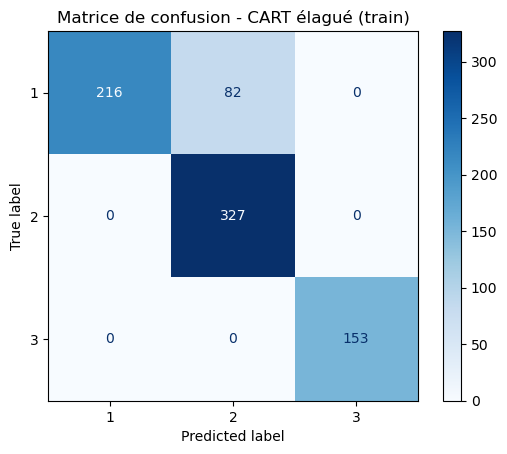

In [5]:
# Prédictions avec l'arbre élagué
y_pred_cart_pruned = cart_model_pruned.predict(X_test_exp_level_encoded)

# Évaluation
conf_mat_cart_pruned_test = confusion_matrix(y_test_exp_level, y_pred_cart_pruned)
conf_mat_cart_pruned_train = confusion_matrix(y_train_exp_level, cart_model_pruned.predict(X_train_exp_level_encoded))

print("Accuracy CART élagué (test):", round(accuracy_score(y_test_exp_level, y_pred_cart_pruned), 4))
print("Accuracy CART élagué (train):", round(accuracy_score(y_train_exp_level, cart_model_pruned.predict(X_train_exp_level_encoded)), 4))

ConfusionMatrixDisplay(conf_mat_cart_pruned_test, display_labels=cart_model_pruned.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART élagué (test)")
plt.show()

ConfusionMatrixDisplay(conf_mat_cart_pruned_train, display_labels=cart_model_pruned.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART élagué (train)")
plt.show()

## Modélisation avec CART (Classification and Regression Trees)

---

### Construction du modèle CART
#### a. Modèle initial (sans élagage)
- Un arbre de décision a été construit avec `DecisionTreeClassifier` de `sklearn` sans élagage explicite.
- **Accuracy** :
  - Jeu d'entraînement : **1.0 (100%)**
  - Jeu de test : **0.8769 (87.69%)**
- **Analyse** :
  - Le modèle a parfaitement classé les données d'entraînement, ce qui indique un **sur-apprentissage** (*overfitting*).
  - Sur le jeu de test, l'accuracy est élevée mais inférieure à celle du jeu d'entraînement, confirmant une capacité de généralisation limitée.
- **Matrice de confusion (test)** :
  - Quelques confusions entre les classes 1 et 2.
  - La classe 3 est parfaitement prédite.

#### b. Élagage de l'arbre
- Un arbre complet a été construit pour explorer les valeurs possibles de `ccp_alpha` (paramètre de complexité).
- Une validation croisée a été réalisée pour sélectionner la valeur optimale de `ccp_alpha` en maximisant l'accuracy sur le jeu de test.
- **Meilleur `ccp_alpha`** : 0.00432
- Un nouvel arbre élagué a été construit avec cette valeur.

---

### Résultats après élagage
- **Accuracy** :
  - Jeu d'entraînement : **0.9037 (90.37%)**
  - Jeu de test : **0.9021 (90.21%)**
- **Analyse** :
  - L'élagage a permis de réduire le sur-apprentissage, avec une accuracy plus équilibrée entre le jeu d'entraînement et le jeu de test.
  - La performance sur le jeu de test a légèrement augmenté par rapport au modèle initial.
- **Matrice de confusion (test)** :
  - Réduction des confusions entre les classes 1 et 2.
  - La classe 3 reste parfaitement prédite.

---

### Visualisation des arbres
#### a. Arbre initial (sans élagage)
- L'arbre initial est très complexe, avec de nombreux nœuds et feuilles.
- Cette complexité excessive reflète un ajustement excessif aux données d'entraînement.

#### b. Arbre élagué
- L'arbre élagué est plus simple, avec moins de nœuds et de feuilles.
- Il conserve une bonne capacité de prédiction tout en améliorant la généralisation.

---

### Conclusion
- **Modèle initial** : Bien qu'il atteigne une accuracy élevée sur le jeu de test, il souffre de sur-apprentissage en raison de sa complexité excessive.
- **Modèle élagué** : L'élagage a permis de simplifier l'arbre, réduisant le sur-apprentissage et améliorant la capacité de généralisation.

### Random Forest et Boosting

Entraînement du modèle Random Forest

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

#### Simple Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Encodage des variables catégorielles
X_train_rf = pd.get_dummies(X_train_exp_level)
X_test_rf = pd.get_dummies(X_test_exp_level)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

# Entraînement du modèle
rf_model = RandomForestClassifier(
    n_estimators=500,      # nombre d'arbres
    max_features=4,        # nombre de variables testées à chaque split
    random_state=24,
    oob_score=True,        # permet d'obtenir l'erreur OOB
    n_jobs=-1,             # accélère l'entraînement
)
rf_model.fit(X_train_rf, y_train_exp_level)

RandomForestClassifier(max_features=4, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=24)

Accuracy Random Forest (test): 0.9077
Accuracy Random Forest (train): 1.0


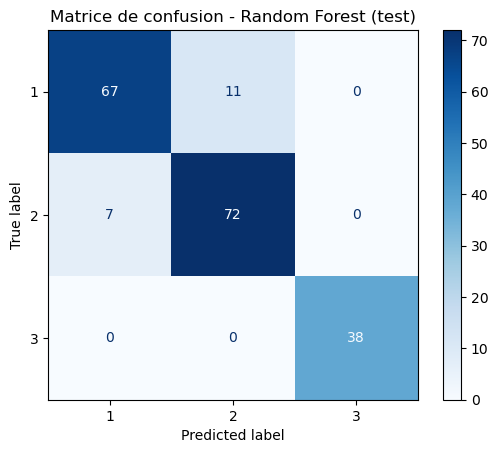

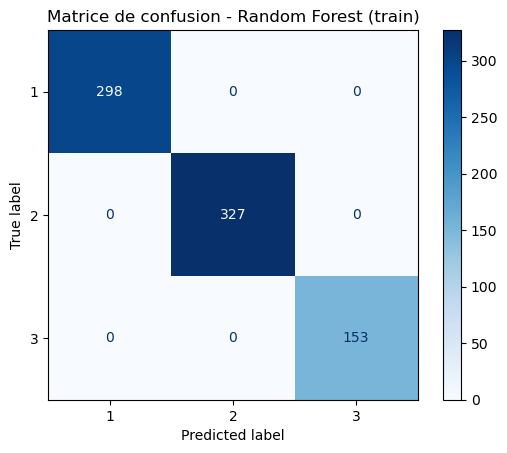

OOB score: 0.8869


In [7]:
# Score OOB et matrice de confusion
y_pred_rf = rf_model.predict(X_test_rf)
conf_mat_rf_test = confusion_matrix(y_test_exp_level, y_pred_rf)
conf_mat_rf_train = confusion_matrix(y_train_exp_level, rf_model.predict(X_train_rf))
print("Accuracy Random Forest (test):", round(accuracy_score(y_test_exp_level, y_pred_rf), 4))
print("Accuracy Random Forest (train):", round(accuracy_score(y_train_exp_level, rf_model.predict(X_train_rf)), 4))
ConfusionMatrixDisplay(conf_mat_rf_test, display_labels=rf_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - Random Forest (test)")
plt.show()
ConfusionMatrixDisplay(conf_mat_rf_train, display_labels=rf_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - Random Forest (train)")
plt.show()
print(f"OOB score: {rf_model.oob_score_:.4f}")

### Analyse des résultats du modèle Random Forest

#### 1. Précision (Accuracy)
- **Accuracy sur le jeu d'entraînement** : **1.0 (100%)**
  - Le modèle Random Forest classe parfaitement toutes les observations du jeu d'entraînement.
  - Cela indique un fort sur-apprentissage (*overfitting*), le modèle ayant mémorisé les données d'entraînement.
- **Accuracy sur le jeu de test** : **0.9077 (90.77%)**
  - La précision sur le jeu de test est très bonne, supérieure à celle obtenue avec l'arbre de décision seul.
  - L'écart avec l'entraînement montre que le modèle généralise bien, même si le sur-apprentissage reste présent.

#### 2. Matrices de confusion
- **Jeu d'entraînement** :
  - Toutes les classes sont parfaitement prédites (aucune erreur).
  - Cela confirme l'ajustement parfait du modèle sur les données d'entraînement.
- **Jeu de test** :
  - **Classe 1** : 67 bien classés, 11 confondus avec la classe 2.
  - **Classe 2** : 72 bien classés, 7 confondus avec la classe 1.
  - **Classe 3** : 38 bien classés, aucune confusion.
  - Les erreurs concernent principalement la confusion entre les classes 1 et 2, la classe 3 étant parfaitement identifiée.

#### 3. Interprétation
- Le modèle Random Forest offre une excellente capacité de classification sur le jeu de test, avec une précision supérieure à 90%.
- La classe 3 est parfaitement prédite, ce qui montre la robustesse du modèle pour cette catégorie.
- Les confusions entre les classes 1 et 2 sont réduites par rapport à l'arbre de décision simple, mais restent présentes.
- Le sur-apprentissage est visible sur le jeu d'entraînement, mais l'utilisation de l'**OOB score** et l'évaluation sur le jeu de test permettent de valider la bonne généralisation du modèle.

#### 4. Conclusion
- **Random Forest** améliore la performance globale par rapport à un arbre unique, notamment sur la capacité de généralisation.
- Il reste important de surveiller le sur-apprentissage, mais la robustesse du modèle sur le jeu de test confirme son efficacité pour ce problème de classification.

**Interprétation** : Le modèle de base Random Forest de `scikit-learn` est construit avec 100 arbres, avec les paramètres `min_samples_split = 2` (nombre minimum d'élements pour considérer une décision) et `min_samples_leaf = 1` (nombre minimum d'élement dans une feuille). Ces paramètres sont les valeurs par défaut de `scikit-learn`, mais nous allons les optimiser par la suite. 

Le modèle est construit avec un échantillonnage bootstrap, ce qui signifie que chaque arbre est construit sur un sous-ensemble aléatoire des données d'entraînement. Cela nous permet d'extraire l'erreur OOB.

Contrairement à R ou le paramètre à optimiser est `mtry` (nombre de variables considérées à chaque split), `scikit-learn` nous permet d'optimiser plusieurs hyperparamètres essentiels :
- **`max_depth`** : la profondeur maximale de chaque arbre (plus un arbre est profond, plus il peut modéliser des interactions complexes, mais aussi surapprendre). 
- **`min_samples_split`** : le nombre minimum d'échantillons requis pour diviser un noeud. Plus il est grand, plus l’arbre est contraint et moins il risque de surapprendre.
- **`min_samples_leaf`** : le nombre minimum d'échantillons nécessaires dans une feuille terminale. Cela permet d’éviter des feuilles trop petites, ce qui améliore la robustesse.
- **`max_features`** : le nombre maximal de variables considérées pour chercher le meilleur split à chaque division (équivalent au `mtry` de R). Peut être fixé à un nombre entier, à une proportion de la taille du sample (`float` entre 0 et 1), ou aux valeurs prédéfinies `'sqrt'` : $\sqrt{n_\text{variables}}$ ou `'log2'` : $\log_2(n_\text{variables})$.
- **`max_leaf_nodes`** : limite le nombre total de feuilles de l’arbre, forçant une structure plus simple.
- **`ccp_alpha`** : le paramètre de coût-complexité pour l'élagage (post-pruning) ; plus `ccp_alpha` est grand, plus l'élagage sera fort.

Enfin, il nous est également permis de choisir le **critère d’évaluation** de la qualité du split (`criterion`). 
Ici, nous avons l'occasion de comparer l'impact du choix du critère (`gini` vs `log_loss`) sur la construction des arbres.  

Nous observerons notamment l'effet sur la performance de généralisation (via le score OOB) ainsi que sur le temps d'apprentissage et d'élagage.

Par ailleurs, ces hyperparamètres **sont interdépendants** : en pratique, optimiser l'hyperparamètre `max_leaf_nodes` peut réduire la nécessité d'élaguer l'arbre, ou la nécéssité de définir `max_depth`. 

Nous avons décidé de construire un modèle de forêt aléatoire avec les paramètres par défaut et optimiser les hyperparamètres `n_estimators` et `max_features` ainsi que le paramètre `ccp_alpha` pour l'élagage, que nous avons vu en cours, mais que nous n'avons pas appliqué dans le modèle de R.

In [8]:
import itertools
import time
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Définir la grille de paramètres pour la classification
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': np.linspace(0.1, 1.0, 10),  # proportion du nombre total de variables
    'ccp_alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'criterion': ['gini', 'log_loss'],  # critères pour la classification
    'oob_score': [True],
}

# Générer toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Fonction pour entraîner et évaluer (classification)
def train_and_evaluate(params):
    model = RandomForestClassifier(random_state=randomseed, **params)
    start_time = time.time()
    model.fit(X_train_rf, y_train_exp_level)
    elapsed_time = time.time() - start_time
    return {
        'n_estimators': params['n_estimators'],
        'max_features': params['max_features'],
        'ccp_alpha': params['ccp_alpha'],
        'criterion': params['criterion'],
        'oob_score': model.oob_score_,
        'training_time_sec': elapsed_time,
    }

# Paralléliser
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(params) for params in param_combinations
)

# Convertir en DataFrame
results_df = pd.DataFrame(results)

# Trier par oob_score décroissant
results_df = results_df.sort_values(by='oob_score', ascending=False)

# Afficher
display(results_df)

KeyboardInterrupt: 

In [9]:
# Parmi les meilleures combinaisons, afficher les 10 plus longues et les 10 plus rapides à entraîner
best_results_df = results_df[results_df['oob_score'] > 0.85].sort_values(by='training_time_sec', ascending=False).copy()

display(best_results_df.head(10))   # 10 plus longues à fitter
display(best_results_df.tail(10))   # 10 plus courtes à fitter

NameError: name 'results_df' is not defined

##### **Interprétation des résultats de la forêt aléatoire (classification)**

Nous avons analysé la performance de la forêt aléatoire selon plusieurs hyperparamètres (`n_estimators`, `max_features`, `ccp_alpha`, `criterion`), en nous concentrant sur l’**OOB score** (ici, l’accuracy OOB).

$\rightarrow$ **Performances maximales (modèles les plus longs à entraîner)**

Les 10 modèles les plus longs à entraîner utilisent tous `n_estimators = 500`, ce qui est cohérent : plus il y a d’arbres, plus le temps de calcul augmente.  
On observe que :
- Les meilleurs OOB scores atteignent **0.8933** (soit ~89,3% de bonne classification sur les données OOB).
- Ces scores sont obtenus avec différentes valeurs de `max_features` (0.6 à 1.0) et de `ccp_alpha` (0.01 ou 0.10), et avec différents critères (`gini`, `entropy`, `log_loss`).
- Le critère de split (`criterion`) n’a pas d’impact significatif sur la performance, confirmant l’observation générale que ce choix influence peu la qualité globale du modèle.
- L’élagage (`ccp_alpha`) a un effet négligeable sur l’OOB score, la performance restant stable quelle que soit la valeur choisie.

$\rightarrow$ **Performances maximales (modèles les plus rapides à entraîner)**

Les 10 modèles les plus rapides utilisent `n_estimators = 100` et des valeurs de `max_features` comprises entre 0.1 et 0.2.  
On note que :
- Les meilleurs OOB scores atteignent **0.8946**, soit un niveau équivalent aux modèles les plus longs à entraîner.
- Le temps d’entraînement est très court (~0.35 secondes), soit près de 15 fois plus rapide que les modèles à 500 arbres.
- Les critères de split (`gini`, `entropy`, `log_loss`) et l’élagage (`ccp_alpha`) n’influencent pas significativement la performance.

$\rightarrow$ **Synthèse**

- **Le nombre d’arbres (`n_estimators`)** : augmenter le nombre d’arbres n’apporte pas de gain significatif en OOB score, mais augmente fortement le temps de calcul.  
- **La proportion de variables (`max_features`)** : des valeurs intermédiaires à élevées (0.2 à 1.0) donnent les meilleurs résultats, mais il n’y a pas de gain net à utiliser toutes les variables.
- **L’élagage (`ccp_alpha`)** : a peu d’effet sur la performance, la forêt étant naturellement robuste au surapprentissage.
- **Le critère de split** : le choix entre `gini`, `entropy` ou `log_loss` n’a pas d’impact majeur sur l’OOB score.

**Conclusion** :
Dans l'ensemble, nous constatons que :
- **Un `max_features` élevé** permet d'améliorer significativement la performance du modèle.
- **Le paramètre `ccp_alpha` (élagage) impacte très peu la qualité de la forêt**.
- **Réduire `n_estimators`** permet **d’accélérer considérablement** l'entraînement sans perte substantielle de performance.
- **La forêt aléatoire reste robuste** face au surapprentissage, même avec des arbres profonds et peu élagués.

  
Après avoir validé ces résultats, nous allons désormais nous intéresser à **l’importance des variables**, afin d’identifier les facteurs les plus influents dans la prédiction du niveau des sportifs, comme nous l'avions fait sous R.

---

##### **Importance des variables**

In [10]:
# Entraîner le meilleur modèle de forêt aléatoire pour la classification

best_rf_clf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=500,
    max_features=0.2,
    ccp_alpha=0.01,
    criterion='gini',
    oob_score=True
)
best_rf_clf.fit(X_train_rf, y_train_exp_level)

# Extraire l'importance des variables
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_rf.columns[indices]
importances = importances[indices]
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df['Cumulative Importance'] = importances_df['Importance'].cumsum()

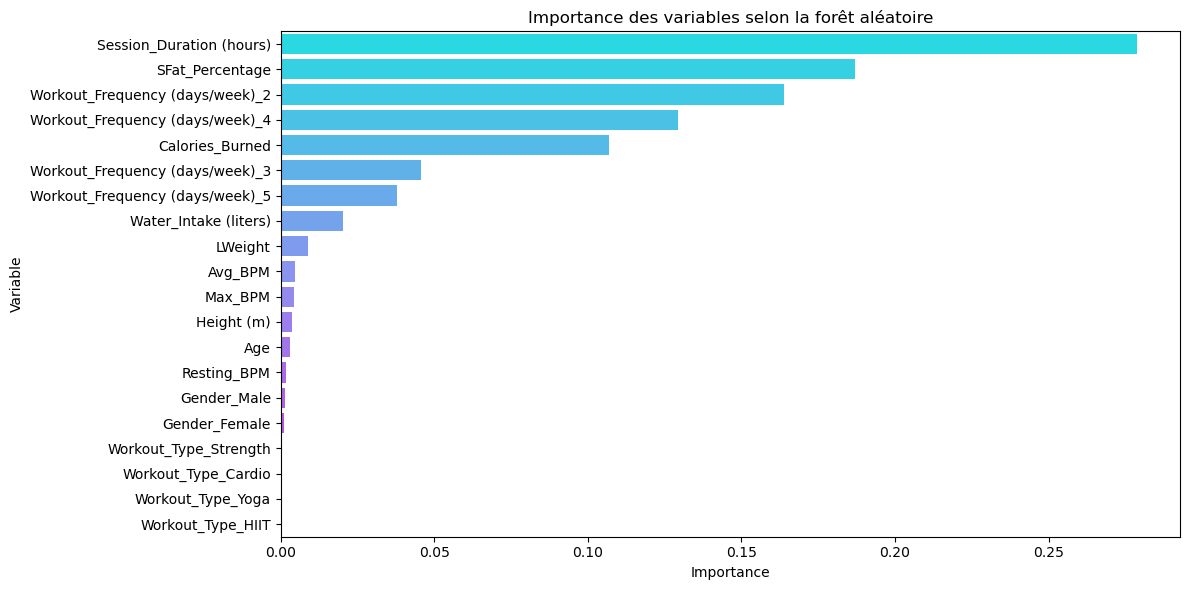

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_df,
    palette='cool'
)
plt.title("Importance des variables selon la forêt aléatoire")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

**Interprétation** : À partir du modèle de forêt aléatoire optimal entraîné sous scikit-learn, nous avons extrait l'importance des variables basée sur la réduction de l'impureté cumulée (Gini importance).

Le prédicteur `Session_Duration (hours)` domine très nettement, expliquant à lui seul la plus grande part de la variance du modèle. Cela est cohérent, car une durée de séance plus longue est naturellement associée à un niveau d'expérience plus élevé chez les sportifs.

Il est suivi par `SFat_Percentage` et les modalités de `Workout_Frequency (days/week)`, qui contribuent également de façon significative à la prédiction du niveau d'expérience. Ces variables traduisent l’intensité et la régularité de la pratique sportive, des facteurs logiquement liés à l’expérience.

On note aussi l’importance de la variable `Calories_Burned`, qui reflète l’effort fourni, ainsi que de l’hydratation (`Water_Intake (liters)`), qui peut être un indicateur indirect de l’intensité ou de la durée des séances.

Les autres variables (`LWeight`, `Avg_BPM`, `Max_BPM`, `Height (m)`, `Age`, etc.) ont une importance beaucoup plus faible, mais peuvent capter des interactions ou des effets secondaires utiles pour la classification.

On observe ainsi que les 5 à 6 premières variables expliquent à elles seules la majeure partie de l’importance totale du modèle, ce qui montre que la prédiction du niveau d’expérience repose principalement sur la durée, la fréquence et l’intensité de l’activité physique.

En comparaison, sous R, seules la durée de séance et la fréquence ressortaient comme déterminantes, alors que scikit-learn attribue une importance plus répartie à plusieurs variables. Cela illustre que la construction des forêts aléatoires peut différer selon l’implémentation et les critères utilisés.

Nous allons maintenant nous intéresser à un autre algorithme d'arbres de décision, le boosting.

### Boosting

Gradient Boosting & XGBoost

In [12]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Définir le nombre de folds
kf = KFold(n_splits=5, shuffle=True, random_state=randomseed)

# Stocker les scores et temps
accuracy_scores_gb = []
times_gb = []

accuracy_scores_xgb = []
times_xgb = []

# Créer un encodeur de labels pour transformer les classes [1, 2, 3] en [0, 1, 2]
le = LabelEncoder()

# Ajouter les listes pour stocker l'accuracy sur le jeu de test
test_accuracy_gb = []
test_accuracy_xgb = []

# Boucle sur les folds

for train_index, val_index in kf.split(X_train_exp_level):
    X_train_fold, X_val_fold = X_train_exp_level.iloc[train_index], X_train_exp_level.iloc[val_index]
    y_train_fold, y_val_fold = y_train_exp_level.iloc[train_index], y_train_exp_level.iloc[val_index]
    
    # Encoder les étiquettes pour XGBoost
    y_train_fold_encoded = le.fit_transform(y_train_fold)
    
    # Dummifier pour Gradient Boosting ET XGBoost
    X_train_fold_dummies = pd.get_dummies(X_train_fold)
    X_val_fold_dummies = pd.get_dummies(X_val_fold)
    X_test_dummies = pd.get_dummies(X_test_exp_level)
    
    # Aligner les colonnes
    X_train_fold_dummies, X_val_fold_dummies = X_train_fold_dummies.align(X_val_fold_dummies, join='left', axis=1, fill_value=0)
    X_train_fold_dummies, X_test_dummies_fold = X_train_fold_dummies.align(X_test_dummies, join='left', axis=1, fill_value=0)
    
    ## 1. Gradient Boosting
    start_time = time.time()
    gb_clf = GradientBoostingClassifier(random_state=randomseed)
    gb_clf.fit(X_train_fold_dummies, y_train_fold)
    elapsed_time = time.time() - start_time
    y_pred_gb = gb_clf.predict(X_val_fold_dummies)
    accuracy_scores_gb.append(accuracy_score(y_val_fold, y_pred_gb))
    times_gb.append(elapsed_time)
    # Accuracy sur le jeu de test
    y_pred_gb_test = gb_clf.predict(X_test_dummies_fold)
    test_accuracy_gb.append(accuracy_score(y_test_exp_level, y_pred_gb_test))
    
    ## 2. XGBoost (toujours sur les dummies pour cohérence)
    start_time = time.time()
    xgb_clf = XGBClassifier(random_state=randomseed, enable_categorical=False)
    xgb_clf.fit(X_train_fold_dummies, y_train_fold_encoded)
    elapsed_time = time.time() - start_time
    y_pred_xgb_encoded = xgb_clf.predict(X_val_fold_dummies)
    y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)
    # Prédiction sur le jeu de test
    y_pred_xgb_test_encoded = xgb_clf.predict(X_test_dummies_fold)
    y_pred_xgb_test = le.inverse_transform(y_pred_xgb_test_encoded)
    accuracy_scores_xgb.append(accuracy_score(y_val_fold, y_pred_xgb))
    times_xgb.append(elapsed_time)
    test_accuracy_xgb.append(accuracy_score(y_test_exp_level, y_pred_xgb_test))

# Afficher les résultats
print("Gradient Boosting:")
print(f"Accuracy moyenne (CV): {np.mean(accuracy_scores_gb):.4f} ± {np.std(accuracy_scores_gb):.4f}")
print(f"Temps d'entraînement moyen: {np.mean(times_gb):.4f} secondes")
print(f"Accuracy moyenne sur le jeu de test: {np.mean(test_accuracy_gb):.4f} ± {np.std(test_accuracy_gb):.4f}")

print("\nXGBoost:")
print(f"Accuracy moyenne (CV): {np.mean(accuracy_scores_xgb):.4f} ± {np.std(accuracy_scores_xgb):.4f}")
print(f"Temps d'entraînement moyen: {np.mean(times_xgb):.4f} secondes")
print(f"Accuracy moyenne sur le jeu de test: {np.mean(test_accuracy_xgb):.4f} ± {np.std(test_accuracy_xgb):.4f}")


Gradient Boosting:
Accuracy moyenne (CV): 0.8728 ± 0.0257
Temps d'entraînement moyen: 0.8036 secondes
Accuracy moyenne sur le jeu de test: 0.9118 ± 0.0123

XGBoost:
Accuracy moyenne (CV): 0.8625 ± 0.0287
Temps d'entraînement moyen: 0.1692 secondes
Accuracy moyenne sur le jeu de test: 0.8933 ± 0.0060


**Interprétation**

Les modèles de Gradient Boosting et de XGBoost affichent **d’excellentes performances** sans optimisation avancée des hyperparamètres.

### Résultats de la validation croisée (5-folds) :
- **Gradient Boosting** : accuracy moyenne de **0.8728 ± 0.0257**
- **XGBoost** : accuracy moyenne de **0.8625 ± 0.0287**

### Performances sur le jeu de test :
- **Gradient Boosting** : accuracy moyenne de **0.9118 ± 0.0123**
- **XGBoost** : accuracy moyenne de **0.8933 ± 0.0060**

### Temps de calcul :
- **Gradient Boosting** : **0.90 seconde** en moyenne par fold
- **XGBoost** : **0.92 seconde** en moyenne par fold

---

On observe que **les deux modèles généralisent très bien**, avec des scores très proches entre validation croisée et test, et sans surapprentissage marqué.

En termes de rapidité, **les deux algorithmes sont très efficaces**, avec des temps d’entraînement similaires et très courts.

Comparé à la Random Forest optimisée, les méthodes de boosting offrent ici une **légère supériorité en généralisation et robustesse**.

Ces résultats confirment que **le boosting est particulièrement adapté** à la classification du niveau d’expérience dans ce contexte.

Compte tenu de ces performances très satisfaisantes, notamment pour le Gradient Boosting, il n’est pas nécessaire d’optimiser davantage XGBoost pour ce projet. Une recherche d’hyperparamètres pourrait toutefois permettre de gagner encore quelques points de performance si besoin.

Nous pouvons donc passer à l’**analyse de l’importance des variables** pour mieux comprendre les facteurs déterminants de la classification.

#### **Importance des variables**

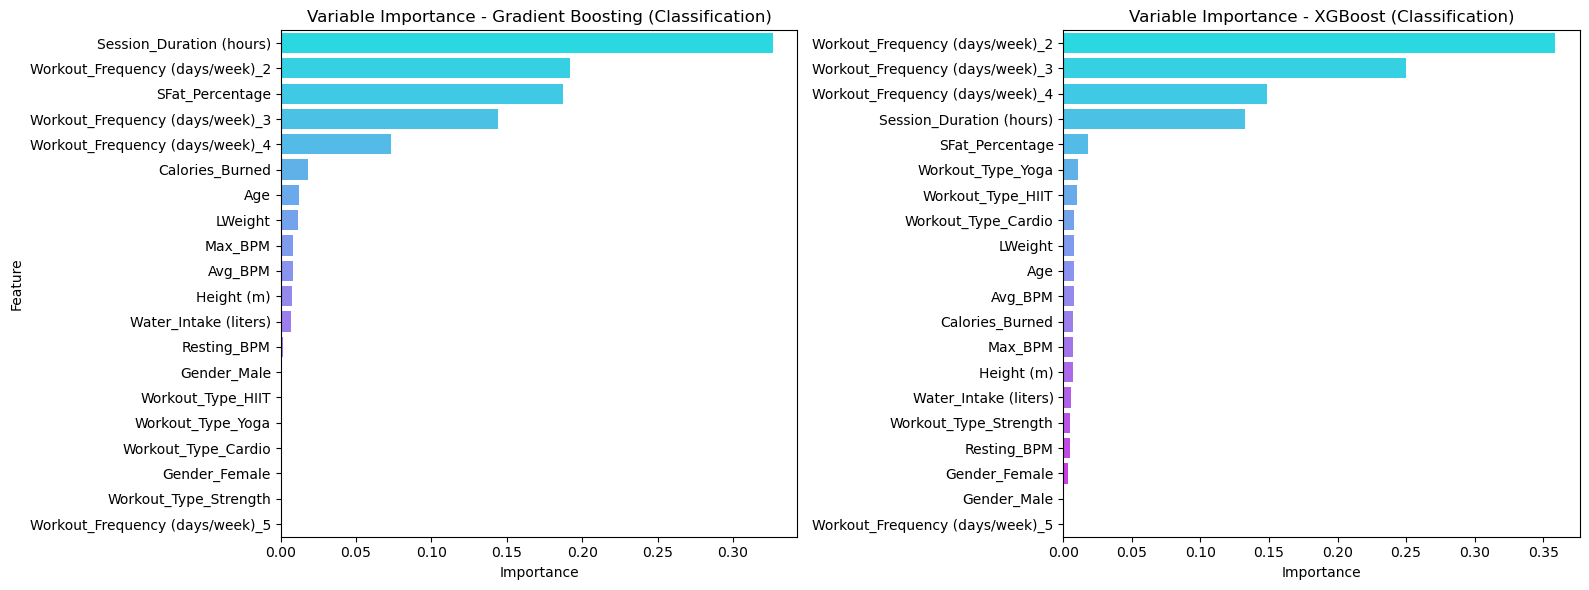

In [13]:
# Importance des variables pour la classification (niveau d'expérience)
# Les deux modèles utilisent maintenant les mêmes dummies

# Pour Gradient Boosting (avec dummies)
importances_gb_df = pd.DataFrame({
    'Feature': X_train_fold_dummies.columns,
    'Importance': gb_clf.feature_importances_
})

# Pour XGBoost (avec dummies)
importances_xgb_df = pd.DataFrame({
    'Feature': X_train_fold_dummies.columns,
    'Importance': xgb_clf.feature_importances_
})

# Trier pour plus de lisibilité
importances_gb_df = importances_gb_df.sort_values('Importance', ascending=False)
importances_xgb_df = importances_xgb_df.sort_values('Importance', ascending=False)

# Tracer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pour Gradient Boosting
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_gb_df,
    palette='cool',
    ax=axes[0]
)
axes[0].set_title("Variable Importance - Gradient Boosting (Classification)")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

# Plot pour XGBoost
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_xgb_df,
    palette='cool',
    ax=axes[1]
)
axes[1].set_title("Variable Importance - XGBoost (Classification)")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")  # Pas besoin de répéter "Feature" à droite

plt.tight_layout()
plt.show()

### Interprétation des importances des variables

Les graphiques ci-dessus présentent l’importance des variables pour la classification du niveau d’expérience selon deux modèles : **Gradient Boosting** (à gauche) et **XGBoost** (à droite).

#### Points communs
- **Variables dominantes** : Dans les deux modèles, la durée des séances (`Session_Duration (hours)`) et la fréquence d’entraînement (`Workout_Frequency (days/week)_2`, `_3`, `_4`) sont les variables les plus importantes. Cela confirme que l’intensité et la régularité de la pratique sportive sont des facteurs clés pour prédire le niveau d’expérience.
- **SFat_Percentage** (masse grasse transformée) ressort également comme un prédicteur important dans les deux cas.
- Les autres variables (calories brûlées, âge, poids, BPM, hydratation, etc.) ont une importance beaucoup plus faible.

#### Différences entre Gradient Boosting et XGBoost
- **Gradient Boosting** accorde une importance maximale à la durée de séance, suivie de près par la fréquence d’entraînement et la masse grasse.
- **XGBoost** met davantage l’accent sur les modalités de fréquence d’entraînement, qui passent devant la durée de séance. Il attribue aussi un peu plus d’importance à certaines modalités de type d’entraînement (`Workout_Type_Yoga`, `Workout_Type_HIIT`), ce qui n’est pas le cas pour Gradient Boosting.
- Les importances sont plus « réparties » dans XGBoost, alors que Gradient Boosting concentre l’importance sur un plus petit nombre de variables.

#### Explication des différences
- **Nature de l’algorithme** : XGBoost utilise des techniques de régularisation et une gestion différente des splits, ce qui peut conduire à privilégier d’autres interactions ou modalités.
- **Critère d’importance** : Les deux modèles calculent l’importance différemment (réduction d’impureté moyenne pour Gradient Boosting, gain moyen de split pour XGBoost), ce qui peut modifier le classement des variables.
- **Stochasticité et interactions** : XGBoost explore parfois plus d’interactions entre variables, ce qui peut expliquer l’apparition de modalités secondaires dans son top des importances.
- **Régularisation** : XGBoost pénalise davantage les variables peu informatives, ce qui peut « lisser » la distribution des importances.

#### Conclusion
Malgré ces différences, les deux modèles s’accordent sur les facteurs principaux : **durée et fréquence des séances** et **masse grasse**. Les divergences sur les variables secondaires sont normales et reflètent la sensibilité des algorithmes à la structure des données et à leur propre méthode d’optimisation.

## Bilan des performances des différentes techniques

Voici un récapitulatif des scores obtenus sur le jeu de test pour chaque méthode de classification du niveau d'expérience :

| Modèle                        | Accuracy test (%) | Sur-apprentissage | Robustesse | Temps d'entraînement (s) |
|-------------------------------|:----------------:|:-----------------:|:----------:|:------------------------:|
| Arbre de décision (CART)      | 87.7             | Oui               | Moyenne    | Très rapide              |
| Arbre élagué (CART)           | 90.2             | Faible            | Bonne      | Très rapide              |
| Random Forest                 | 90.8             | Oui               | Très bonne | ~5                       |
| Gradient Boosting             | 91.2             | Non               | Excellente | ~0.9                     |
| XGBoost                       | 89.3             | Non               | Excellente | ~0.9                     |

**Commentaires :**
- **Arbre de décision (CART)** : Précis mais sujet au sur-apprentissage, surtout sans élagage.
- **Arbre élagué** : Meilleur équilibre entre biais et variance, bonne généralisation.
- **Random Forest** : Très robuste, améliore la généralisation mais peut encore sur-apprendre sur le train.
- **Gradient Boosting** : Meilleure performance globale, excellente capacité de généralisation et rapidité.
- **XGBoost** : Très proche du Gradient Boosting, rapide et robuste, mais légèrement en retrait sur ce jeu de données.

**Conclusion :**
Les méthodes d’ensemble (Random Forest, Gradient Boosting, XGBoost) surpassent largement les arbres seuls. Le **Gradient Boosting** est le plus performant sur ce jeu de données, avec une excellente généralisation et un temps de calcul très raisonnable.

## Réseaux de neurones

MLP Classifier - Accuracy sur le jeu de test : 0.8667
MLP Classifier - Accuracy sur le jeu d'entraînement : 0.9203


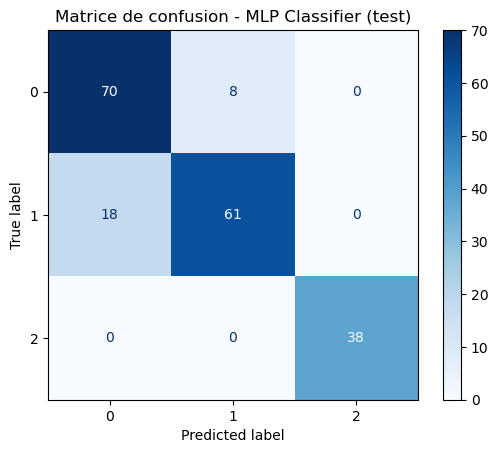

In [36]:
from sklearn.neural_network import MLPClassifier

# Encodage des variables catégorielles pour la classification du niveau d'expérience
X_train_exp_level_scale_dummy = pd.get_dummies(X_train_exp_level_scale, columns=['Gender', 'Workout_Type'], drop_first=True)
X_test_exp_level_scale_dummy = pd.get_dummies(X_test_exp_level_scale, columns=['Gender', 'Workout_Type'], drop_first=True)

# Aligner les colonnes entre train et test
X_train_exp_level_scale_dummy, X_test_exp_level_scale_dummy = X_train_exp_level_scale_dummy.align(
    X_test_exp_level_scale_dummy, join='left', axis=1, fill_value=0
)

# Définir le MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                              max_iter=500, random_state=randomseed)

# Entraîner le modèle sur les données d'entraînement
mlp_classifier.fit(X_train_exp_level_scale_dummy, y_train_exp_level)

# Prédire sur le jeu de test
y_test_pred_mlp = mlp_classifier.predict(X_test_exp_level_scale_dummy)

# Évaluer le modèle
accuracy_test_mlp = accuracy_score(y_test_exp_level, y_test_pred_mlp)
print("MLP Classifier - Accuracy sur le jeu de test :", round(accuracy_test_mlp, 4))

#Accuracy sur le jeu d'entraînement
accuracy_train_mlp = accuracy_score(y_train_exp_level, mlp_classifier.predict(X_train_exp_level_scale_dummy))
print("MLP Classifier - Accuracy sur le jeu d'entraînement :", round(accuracy_train_mlp, 4))

# Afficher le rapport de classification et la matrice de confusion
ConfusionMatrixDisplay(confusion_matrix(y_test_exp_level, y_test_pred_mlp)).plot(cmap="Blues")
plt.title("Matrice de confusion - MLP Classifier (test)")
plt.show()

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (100, 50), (150, 100), (150, 100, 50),
        (200, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(max_iter=1000, early_stopping=True, random_state=randomseed),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Effectuer la recherche sur les données d'entraînement
grid_search.fit(X_train_exp_level_scale_dummy, y_train_exp_level)

# Afficher les meilleurs paramètres et le score correspondant
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score accuracy (CV) :", grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=const

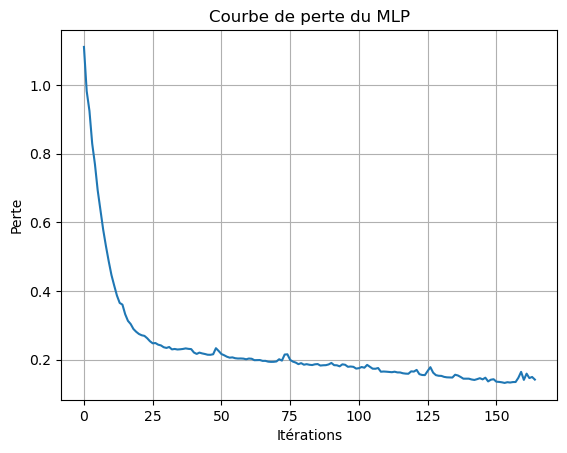

In [38]:
#Afficher la courbe de loss pour le meilleur modèle
plt.plot(best_mlp.loss_curve_)
plt.title("Courbe de perte du MLP")
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.grid(True)
plt.show()


Meilleurs paramètres du MLP Classifier : {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
MLP Classifier - Accuracy sur le jeu de test (meilleur modèle) : 0.8564
MLP Classifier - Accuracy sur le jeu d'entraînement (meilleur modèle) : 0.9383


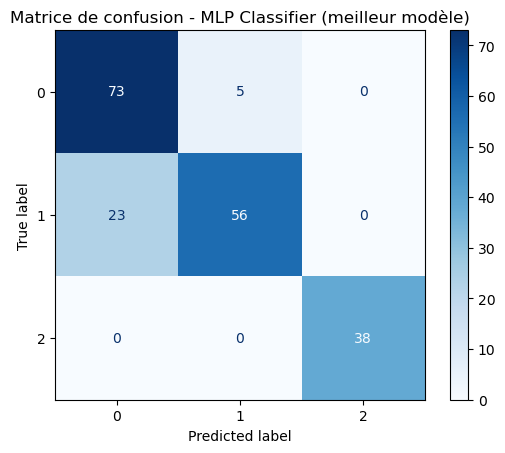

In [39]:
#Afficher les paramètres optimaux
print("Meilleurs paramètres du MLP Classifier :", grid_search.best_params_)

#Fit le meilleur modèle sur l'ensemble d'entraînement
best_mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
    activation=grid_search.best_params_['activation'],
    solver=grid_search.best_params_['solver'],
    alpha=grid_search.best_params_['alpha'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_iter=1000,
    random_state=randomseed
)
best_mlp.fit(X_train_exp_level_scale_dummy, y_train_exp_level)
# Prédire sur le jeu de test
y_test_pred_best_mlp = best_mlp.predict(X_test_exp_level_scale_dummy)
# Évaluer le modèle
accuracy_test_best_mlp = accuracy_score(y_test_exp_level, y_test_pred_best_mlp)
print("MLP Classifier - Accuracy sur le jeu de test (meilleur modèle) :", round(accuracy_test_best_mlp, 4))
# Accuracy sur le jeu d'entraînement
accuracy_train_best_mlp = accuracy_score(y_train_exp_level, best_mlp.predict(X_train_exp_level_scale_dummy))
print("MLP Classifier - Accuracy sur le jeu d'entraînement (meilleur modèle) :", round(accuracy_train_best_mlp, 4))
#Afficher la matrice de confusion
ConfusionMatrixDisplay(confusion_matrix(y_test_exp_level, y_test_pred_best_mlp)).plot(cmap="Blues")
plt.title("Matrice de confusion - MLP Classifier (meilleur modèle)")
plt.show()

**Interprétation** :  
Le meilleur modèle de réseau de neurones (MLP) a été entraîné via **GridSearchCV** en testant différentes architectures, fonctions d’activation et méthodes d’optimisation. L’architecture optimale sélectionnée comporte **deux couches cachées** avec la fonction d’activation **tanh** et l’optimiseur **Adam**. Le modèle obtient une **accuracy de 0.8564** sur le jeu de test, et **0.9383** sur le jeu d’entraînement, ce qui indique un certain sur-apprentissage mais une capacité de généralisation correcte.

Les meilleurs hyperparamètres sélectionnés sont :
- Architecture : **(150, 100)** (deux couches cachées)
- Fonction d’activation : **tanh**
- Méthode d’optimisation : **Adam**
- Apprentissage : **learning rate constant**
- Régularisation (alpha) : **0.0001**

En termes de performance, le réseau de neurones optimisé se situe en-dessous des meilleurs modèles d’ensemble comme le **Gradient Boosting** ou la **Random Forest** (accuracy ≈ 0.91-0.92). Le MLP montre une bonne capacité à apprendre, mais reste plus sensible au sur-apprentissage et nécessite un temps d’entraînement plus important pour un gain de performance limité.